# MT Metrics Correlate with Human Ratings of Simultaneous Speech Translation

IWSLT 2023 short paper

This document shows data used in https://arxiv.org/pdf/2211.08633.pdf

Author: Dominik Macháček, machacek@ufal.mff.cuni.cz

31.5.2023 (previous version was from 25.11.2022)

## TL;DR: Data table with MT Metrics, CR and CRi

See `doc-data-with-MT-metrics-20230105.csv`. The MT metrics BLEU, chrF2 and COMET were created as described in the paper, using the MT sources, references and candidate translations in data package from IWSLT 2022 Findings. 


In [3]:
import pandas as pd
from weighted_avg import *

In [4]:
data = pd.read_csv("doc-data-with-MT-metrics-20230105.csv")
data

,Unnamed: 0,system,latency,common,annotator,doc,CRi,CR,bleu,chrf,comet,bertscore
0,309,FBK,high,False,3,07_bucherinsel-west,1.599400,1.615385,18.3250,42.1269,-0.5649,0.785281
1,310,FBK,high,False,3,09_il-gabbiano,1.297115,1.444444,6.4025,25.6535,-0.6233,0.684360
2,311,FBK,high,False,3,11_trefa,2.403509,2.263158,14.3560,49.5926,-0.2238,0.813380
3,312,FBK,high,False,3,22_new-design-world,1.807797,2.000000,18.6144,40.0341,-0.6229,0.758879
4,313,FBK,high,False,3,27_f-e-international-tour,1.889951,2.000000,12.6761,45.7397,0.0140,0.816580
...,...,...,...,...,...,...,...,...,...,...,...,...
1684,1684,interpreting,NaN,True,43,ted_56901,3.178629,3.218182,NaN,NaN,NaN,NaN
1685,1685,interpreting,NaN,True,44,ted_42604,3.314825,3.186441,NaN,NaN,NaN,NaN
1686,1686,interpreting,NaN,True,45,ted_63920,2.838210,2.877301,NaN,NaN,NaN,NaN
1687,1687,interpreting,NaN,True,48,ted_51101,3.496565,3.355556,NaN,NaN,NaN,NaN


## How CR and CRi were computed

Continuous Rating data originate as `cp-orig-log/data-20220507.csv`. 

Then, we compute CR and CRi with the following:

In [5]:
def read_data2(csv_file):
  """This function was originally created by Barry Haddow for IWSLT 2022 Findings.
  
  Dominik Macháček removes filtering out infrequent annotations. 
  Instead, annot_density column is returned within the data and can be used in later processing."""
  annotators, systems, latencies, docs, lengths, offsets, ratings, run_ids = [], [], [], [], [], [], [], []
  with open(csv_file) as fh:
    reader = csv.DictReader(fh, quotechar="'")
    for row in reader:
      if row['rating'] == "\\N":
        continue
      fields = row['subtitles'].split(".")
      if fields[0] == "interpreting":
        system,latency,doc = fields[0],"",fields[1]
      else:
        system,latency,doc = fields[0], fields[1], fields[2]
      annotator = int(row['annotator_id'])
      run_id = int(row['id'])
      length = float(row['audio_length'])
      for offset, rating in  eval(row['rating'])[1:]:
        offsets.append(int(offset))
        # A rating of 0 means that the annotator lost attention, so we ignore it
        if rating == 0:
            ratings.append(math.nan)
        else:
            ratings.append(int(rating))
        annotators.append(annotator)
        docs.append(doc)
        latencies.append(latency)
        systems.append(system)
        lengths.append(length)
        run_ids.append(run_id)

  data = pd.DataFrame({
    'run_id' : run_ids, # corresponds to id on original data
    "system" : systems,
    "latency" : latencies,
    "annotator" : annotators,
    "doc" : docs,
    "length" : lengths,
    "offset" : offsets,
    "rating" : ratings,

  })
  data['common'] = data['doc'].str.startswith("ted")

  # Data fixes

  LOG.debug(f"Total number of raw ratings: {len(data)}")

  # Remove any ratings which were more than 20 seconds past the end of the audio
  data['diff'] = data['offset'] - data['length']
  data.drop(data[data['diff'] > 20000].index, inplace = True)
  LOG.debug(f"Total ratings after removing late ratings: {len(data)}")


  # Remove runs where the annotator made too few annotations. 
  # We expect at least length / 5 sec annotations, so if less than 1 per 20 secs, remove
  data_by_run = data.groupby(["run_id"])
  annot_density = data_by_run['length'].mean() / data_by_run['length'].count()
  d = dict(annot_density)
  annot_density_col = [d[i] for i in data.run_id]
    
  data.insert(data.shape[1],"annot_density",annot_density_col)
  #print(annot_density)
  #print(50000, len(annot_density[annot_density > 50000]))

  # Dominik removes this, so we use all the annotations
#  short_runs = annot_density[annot_density > 20000].reset_index()
#  data.drop(data[data['run_id'].isin(short_runs['run_id'])].index, inplace=True)

  LOG.debug(f"Total ratings after removing partially rated audios: {len(data)}")
  return data

data2 = read_data2("data-20220507.csv")

def doc_CR_weighted(data,maxlen=float("inf")):
    """groups CR by documents, and adds CRi column"""
    return data.groupby(["system", "latency", "common", "annotator", "doc"]
                       ).apply(weighted_avg_fun,maxlen=maxlen).apply(lambda x: x[0]).to_frame(name="CRi").reset_index()

doc_data = doc_CR_weighted(data2)

def doc_CR_avg(data,maxlen=float("inf")):
    """groups CR by documents, and adds CR column"""
    return data.groupby(["system", "latency", "common", "annotator", "doc"]
                       ).rating.mean().to_frame(name="CR").reset_index()

CR = doc_CR_avg(data2).CR
doc_data.insert(doc_data.shape[1],"CR",CR)

In [6]:
data2

,run_id,system,latency,annotator,doc,length,offset,rating,common,diff,annot_density
0,2294,CUNI-KIT,low,39,ted_37498,905764.0,16308,4.0,True,-889456.0,6759.432836
1,2294,CUNI-KIT,low,39,ted_37498,905764.0,21223,3.0,True,-884541.0,6759.432836
2,2294,CUNI-KIT,low,39,ted_37498,905764.0,26733,3.0,True,-879031.0,6759.432836
3,2294,CUNI-KIT,low,39,ted_37498,905764.0,32861,3.0,True,-872903.0,6759.432836
4,2294,CUNI-KIT,low,39,ted_37498,905764.0,40025,3.0,True,-865739.0,6759.432836
...,...,...,...,...,...,...,...,...,...,...,...
120728,1144,UPV,low,20,spanish,1572552.0,1499831,1.0,False,-72721.0,41382.947368
120729,1144,UPV,low,20,spanish,1572552.0,1535777,2.0,False,-36775.0,41382.947368
120730,1144,UPV,low,20,spanish,1572552.0,1566787,1.0,False,-5765.0,41382.947368
120731,1144,UPV,low,20,spanish,1572552.0,1570375,3.0,False,-2177.0,41382.947368


In [7]:
doc_data

,system,latency,common,annotator,doc,CRi,CR
0,CUNI-KIT,high,False,3,29_salon-n-g,2.474635,2.473684
1,CUNI-KIT,high,False,3,34_kol_action_accessoires,2.963072,2.800000
2,CUNI-KIT,high,False,3,polish,2.627158,2.591954
3,CUNI-KIT,high,False,4,10_magic-travel,3.580270,3.578947
4,CUNI-KIT,high,False,4,22_new-design-world,3.136522,3.000000
...,...,...,...,...,...,...,...
1684,interpreting,,True,43,ted_56901,3.178629,3.218182
1685,interpreting,,True,44,ted_42604,3.314825,3.186441
1686,interpreting,,True,45,ted_63920,2.838210,2.877301
1687,interpreting,,True,48,ted_51101,3.496565,3.355556


## Section 4: Correlation of CR and Metrics

### Table 1

Caption:
Pearson correlation coefficients for CR vs MT metrics BLEU, chrf2, BertScore and COMET for averaged document ratings by all 5 SST systems and 3 latency regimes (upper), and all ratings (lower). 

In [8]:
import scipy

In [9]:
for tab in ["averaged","all"]:
    print("### ",tab,"document ratings")
    print()

    for c in ["both", True, False]:
        print("both/Common subset:",c)
        d = data
        if c != "both":
            d = d[d.common==c]
        d = d[d.system!="interpreting"]
        
        if tab == "averaged":
            d = d.groupby(["system","latency","common","doc"]).mean().reset_index()

        for x in ["CR"]:
            for y in ["bleu","chrf","comet","bertscore"]:
                p, pv = scipy.stats.pearsonr(d[x], d[y])
                # what vs what correlation, Pearson score, p-value, num. of observations
                print(x,y,"%2.2f %2.3f" % (p,pv), d.shape[0])
        print()
    print()

###  averaged document ratings

both/Common subset: both
CR bleu 0.65 0.000 823
CR chrf 0.73 0.000 823
CR comet 0.80 0.000 823
CR bertscore 0.77 0.000 823

both/Common subset: True
CR bleu 0.42 0.000 228
CR chrf 0.63 0.000 228
CR comet 0.76 0.000 228
CR bertscore 0.68 0.000 228

both/Common subset: False
CR bleu 0.70 0.000 595
CR chrf 0.70 0.000 595
CR comet 0.75 0.000 595
CR bertscore 0.73 0.000 595


###  all document ratings

both/Common subset: both
CR bleu 0.61 0.000 1584
CR chrf 0.68 0.000 1584
CR comet 0.73 0.000 1584
CR bertscore 0.71 0.000 1584

both/Common subset: True
CR bleu 0.37 0.000 441
CR chrf 0.57 0.000 441
CR comet 0.68 0.000 441
CR bertscore 0.60 0.000 441

both/Common subset: False
CR bleu 0.64 0.000 1143
CR chrf 0.64 0.000 1143
CR comet 0.67 0.000 1143
CR bertscore 0.66 0.000 1143




### Figure 1

Caption: 
Averaged document CR vs COMET on both Common and Non-native subsets.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

Common subset: None


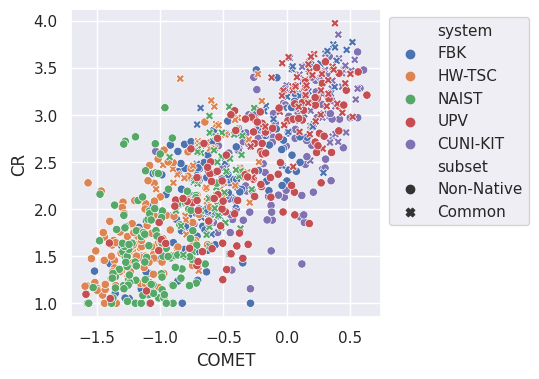

In [12]:
co = None
print("Common subset:",co)
d = data
if co is not None:
    d = d[d.common==co]

d = d.groupby(["system","latency","common","doc"]).mean().reset_index()

d = d[d.system!="interpreting"]

sns.set(rc = {'figure.figsize':(4,4)})

# rename "common" to "subset" column. It sounds better in the legend.
subset_col = ["Common" if x else "Non-Native" for x in d.common ]
d.insert(d.shape[1],"subset",subset_col)

def corrplot(xcol, xlabel, legend):
    ax = sns.scatterplot(data=d,x=xcol,y="CR",
                   style="subset",
                    hue="system",
                    hue_order=["FBK","HW-TSC","NAIST","UPV","CUNI-KIT"],
    legend=legend)
    if legend:
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.xlabel(xlabel)
    plt.autoscale(tight=False)
    pdf = f"plots/corr_CRvs{xlabel}.pdf"
    ax.figure.savefig(pdf,  bbox_inches='tight')
    plt.show()
    
    
    
# corrplot("bleu","BLEU",False)
# corrplot("chrf","chrF2",False)
# corrplot("bertscore","BERTScore",True)
corrplot("comet","COMET",True)


In [ ]:
# other metrics than COMET:
# corrplot("bleu","BLEU",False)
# corrplot("chrf","chrF2",False)
# corrplot("bertscore","BERTScore",True)

## Table 2

Caption: Pearson correlation of metric variants to averaged CR on both subsets, ordered from the most to
the least correlating ones

In [15]:
data = pd.read_csv("doc-metrics-align-20230530.csv")
crdata = pd.read_csv("doc-data-with-MT-metrics-20230105.csv")

In [16]:
CR_col = []
for i,l in data.iterrows():
    if l.level == "document":
        cr = crdata[(crdata.system==l.system)&(crdata.latency==l.latency)&(crdata.doc==l.doc)].CR.mean()
    else:
        cr = None
    CR_col.append(cr)
data.insert(data.shape[1],"CR",CR_col)

In [17]:
# The following cell prints out the values that are in Table 2.
# Later, we sort them by Pearson, transform to Latex, and insert significance layers that we observe in a heatmap

In [18]:
### correlations to CR

corr_data = []

print("# ref, metric, alignment, Pearson score, p-value, num. of observations")
print()

for subs in ["both", "nonn","nat"]:
    print("subset: ", subs)
    for R in ["ref","intp","ref+intp","ref+mw-intp"]:
        #print(R)
        for m in ["bleu",
                  "chrf",
                  "comet-da",
                  "bertscore.f1"
                 ]:
            d = data
            if subs != "both":
                d = d[d.subset==subs]
            
            d = d[d.level=="document"]
            d = d[d.metric==m]
            d = d[d.ref==R]
            d = d[~d.CR.isna()]
            #print("\t",m)

            for a in sorted(list(set(d["align"]))):
                p, pv = scipy.stats.pearsonr(d[d["align"]==a]["CR"], d[d["align"]==a]["value"])
                # ref, metric, alignment, Pearson score, p-value, num. of observations
                print("%12s %14s %10s" % (R,m,a), "%2.2f %2.3f" % (p,pv), d[d["align"]==a].shape[0])
                
                e = (subs, R, m, a, p, "%s %s %s" % (m,R,a))
                corr_data.append(e)
            # uncomment for scatterplots of metric vs CR with different alignments:
#             sns.scatterplot(data=d,x="value",y="CR",hue="align",style="align")
#             plt.show()
    print("_______________________")
    print()

corr_data = pd.DataFrame(corr_data, columns=["subset", "ref","metric","align","pearson","label"])

# ref, metric, alignment, Pearson score, p-value, num. of observations

subset:  both
         ref           bleu    one_seq 0.71 0.000 823
         ref           bleu       sent 0.65 0.000 823
         ref           chrf    one_seq 0.72 0.000 823
         ref           chrf       sent 0.73 0.000 823
         ref       comet-da    one_seq 0.79 0.000 823
         ref       comet-da       sent 0.80 0.000 823
         ref   bertscore.f1    one_seq 0.75 0.000 823
         ref   bertscore.f1       sent 0.77 0.000 823
        intp           bleu       mwer 0.58 0.000 823
        intp           bleu    one_seq 0.65 0.000 823
        intp           chrf       mwer 0.65 0.000 823
        intp           chrf    one_seq 0.66 0.000 823
        intp       comet-da       mwer 0.71 0.000 823
        intp       comet-da    one_seq 0.77 0.000 823
        intp   bertscore.f1       mwer 0.60 0.000 823
        intp   bertscore.f1    one_seq 0.69 0.000 823
    ref+intp           bleu    one_seq 0.73 0.000 

## Appendix D: Pairwise Metric Comparison

In [20]:
# module for correlation significance by Philipp Singer -- see attached corrstats.py
import corrstats

In [21]:
def run_dep_correlation(data, A, B):
    subs, R, m, a, p, label  = A
    _, last_R, last_m, last_a, last_p, last_label = B
    
    
    d = data
    if subs != "both":
        d = d[d.subset==subs]

    d = d[d.level=="document"]
    d = d[d.metric.isin([m, last_m])]
    d = d[d.ref.isin([R, last_R])]
    d = d[d["align"].isin([a, last_a])]
    d = d[~d.CR.isna()]

    #d = d[((d.metric==m)&(d.ref==R)&(d.align==a))|((d.metric==last_m)&(d.ref==last_R)&(d.align==last_a))]
    #print(d)
    pairs = [[],[]]
    def ap(x):
        try:
            A = float(x[(x.metric==m)&(x.ref==R)&(x["align"]==a)].value)
            B = float(x[(x.metric==last_m)&(x.ref==last_R)&(x["align"]==last_a)].value)
            pairs[0].append(A)
            pairs[1].append(B)
        except:
            print(x)
            raise
#                 print(x)
#                 print(a,b)
    d.groupby(["system","latency","subset","doc","level"]).apply(ap)
    #print(pairs)
    co_p, co_pv = scipy.stats.pearsonr(pairs[0],pairs[1])
    if co_pv > 0.01:
        print("It's not significant!")
    #print(d)
    print(co_p, co_pv)
    dc = corrstats.dependent_corr(p, last_p, co_p, len(pairs[0]))
    
    return dc[1], co_p

def sign_level(p):
    if p<0.01:
        return 0.0
    elif p<0.05:
        return 0.05
    elif p<0.1:
        return 0.1
    elif p<0.15:
        return 0.15
    return p

In [ ]:
## Here we generate data for pairwise metrics comparison -- the significance scores. 
## It takes several minutes.
## We save them to heatmap-data.csv and process further in 02-heatmaps-20230531.ipynb

heatmap = []

for subs in ["both", "nonn","nat"]:
    c_data = []

    print("subset: ", subs)
    for R in ["ref","intp","ref+intp","ref+mw-intp"]:
        #print(R)
        for m in ["bleu",
                  "chrf",
                  "comet-da",
                  "bertscore.f1"
                 ]:
            d = data
            if subs != "both":
                d = d[d.subset==subs]
            
            d = d[d.level=="document"]
            d = d[d.metric==m]
            d = d[d.ref==R]
            d = d[~d.CR.isna()]
            #print("\t",m)

            for a in sorted(list(set(d["align"]))):
                p, pv = scipy.stats.pearsonr(d[d["align"]==a]["CR"], d[d["align"]==a]["value"])
                # what vs what correlation, Pearson score, p-value, num. of observations
#                 print("%12s %14s %10s" % (R,m,a), "%2.2f %2.3f" % (p,pv), d[d["align"]==a].shape[0])
                
                e = (subs, R, m, a, p, "%s %s %s" % (m,R,a))
                c_data.append(e)
#             sns.scatterplot(data=d,x="value",y="CR",hue="align",style="align")
#             plt.show()
    c_data = sorted(c_data, key=lambda x:x[4])
    
    for i,A in enumerate(c_data):
        for B in c_data[i+1:]:
            a_b_pv, a_b_pearson = run_dep_correlation(data, A, B)
            t = (*A, *B[1:], a_b_pearson, a_b_pv, sign_level(a_b_pv))
            heatmap.append(t)
            t = (*B, *A[1:], a_b_pearson, a_b_pv, sign_level(a_b_pv))
            heatmap.append(t)
    
        
    print("_______________________")
    print()

            #plt.show()
h = pd.DataFrame(heatmap, columns=["subset","A_ref","A_metric","A_align","A_CR_pearson","A_label",
                                   "B_ref","B_metric","B_align","B_CR_pearson","B_label",
                                   "A_B_pearson",
                                   "A_B_sign_pv","A_B_sign_level"])
h.to_csv("heatmap-data.csv")

subset:  both
0.6551093104917954 4.723021137188355e-102
0.9176574056496967 0.0
0.7856985545538157 2.0049421212690087e-173
0.6687145427684491 8.905349196114876e-108
0.6612621298325161 1.3259381233932684e-104
0.7630181254714803 9.347417079830756e-158
0.7452053025094842 1.233360813003495e-146
0.7253988937890871 2.5942895600325157e-135
0.689520262206893 3.8198028105889955e-117
0.6555644060794201 3.0727970742196712e-102
0.6633925341681611 1.6781774451981895e-105
0.7038015178528922 4.774204908566318e-124
0.7768614859257517 4.23239399217508e-167
0.7286088972614125 4.43798914315211e-137
0.6913221468897034 5.411129114493164e-118
0.7013401914842279 7.906878755971362e-123
0.6414570634252615 1.34149405209803e-96
0.6913699813600357 5.136543176923281e-118
0.6778360845706869 8.672423607100977e-112
0.6548055390588114 6.289999561586437e-102
0.6537198365349592 1.7466281500329387e-101
0.676153360995314 4.88746113520051e-111
0.6680320685135303 1.7540962508523355e-107
0.7331064313031158 1.3445234255395826e